In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
df = pd.read_csv("data.csv",parse_dates=["posted","scraped"])

df = df.loc[df.test==False]

df["age"] = (df.scraped - df.posted).dt.total_seconds()//3600
df["weekday"] = df.posted.dt.day_name()
df["weekday_number"] = df.posted.dt.dayofweek
df["hour"] = df.posted.dt.hour
df["date"] = pd.to_datetime(df.posted.dt.date)
df["year"] = df.posted.dt.year
df["month"] = df.posted.dt.month
df["yrmnth"] = (df.year-2021)*12 + df.month
df["target"] = np.log(df.upvotes+1)

df["fhost"] = df.url.apply(lambda x: "imgur" if "imgur" in x else "reddit")
df["format"] = df.url.apply(lambda x: x.split(".")[-1])



sub = pd.read_csv("subscribers.csv",parse_dates=["timestamp"])

sub["date"] = sub.timestamp.dt.date

sub = sub.pivot(index="date",columns=["subreddit"],values="subscribers")

# Correcting any missing dates
daterange = pd.date_range(start=df.date.min(),end=df.date.max(),freq="D")
sub = sub.reindex(daterange)

# Filling in the new NULL values
sub.interpolate(method="linear",inplace=True)
sub.bfill(inplace=True)


# Adding the date back into the columns so we can melt the updated dataset
sub["date"] = pd.to_datetime(sub.index)
sub = pd.melt(sub,id_vars="date")


# Joining the two dataframes together
df = df.merge(sub.rename(columns={"value":"subscribers"}),how="left",on=["date","subreddit"])





stage1 = df.groupby(["date","subreddit","category","hour"],as_index=False).agg({"upvotes":"count"}).rename(columns={"upvotes":"competition_subreddit"})
stage2 = stage1.groupby(["date","hour","category"],as_index=False).agg({"competition_subreddit":"sum"}).rename(columns={"competition_subreddit":"competition_category"})
stage3 = stage2.groupby(["date","hour"],as_index=False).agg({"competition_category":"sum"}).rename(columns={"competition_category":"competition_total"})



df = df.merge(stage1,how="left",on=["date","hour","subreddit","category"]).merge(stage2,how="left",on=["date","hour","category"]).merge(stage3,how="left",on=["date","hour"])

df.head()



,fname,url,category,subreddit,title,description,upvotes,posted,scraped,niche,...,year,month,yrmnth,target,fhost,format,subscribers,competition_subreddit,competition_category,competition_total
0,cgptykrzcez71.jpg,https://i.redd.it/cgptykrzcez71.jpg,cats,catpictures,Caturday morning TV 😺,NaN,247.0,2021-11-13 11:22:11,2021-11-21 09:28:28.376338,0.0,...,2021,11,11,5.513429,reddit,jpg,142344.0,1,3,12
1,EGjVMqx.jpg,https://i.imgur.com/EGjVMqx.jpg,cats,catpictures,Round loaf!,NaN,24.0,2021-11-13 02:23:31,2021-11-21 09:28:28.376338,0.0,...,2021,11,11,3.218876,imgur,jpg,142344.0,1,2,4
2,y45936kis8z71.jpg,https://i.redd.it/y45936kis8z71.jpg,cats,catpictures,Taken over fall wreath,NaN,427.0,2021-11-12 16:38:49,2021-11-21 09:28:28.376338,0.0,...,2021,11,11,6.059123,reddit,jpg,142344.0,2,6,18
3,irl2nzyro8z71.jpg,https://i.redd.it/irl2nzyro8z71.jpg,cats,catpictures,"My kitten, Topaz!",NaN,196.0,2021-11-12 16:17:45,2021-11-21 09:28:28.376338,0.0,...,2021,11,11,5.283204,reddit,jpg,142344.0,2,6,18
4,vlsh4hijg8z71.jpg,https://i.redd.it/vlsh4hijg8z71.jpg,cats,catpictures,My Tom is not impressed having to wait for the...,NaN,620.0,2021-11-12 15:31:23,2021-11-21 09:28:28.376338,0.0,...,2021,11,11,6.431331,reddit,jpg,142344.0,1,3,14


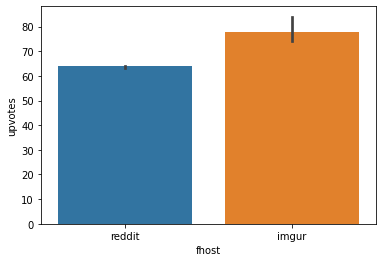

In [32]:
sns.barplot(data=df,x="fhost",y="upvotes",estimator=np.median);

<AxesSubplot:xlabel='hour', ylabel='upvotes'>

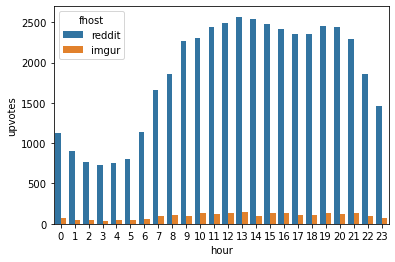

In [33]:
sns.barplot(data=df,x="hour",y="upvotes",estimator=len,hue="fhost")

<AxesSubplot:xlabel='hour', ylabel='upvotes'>

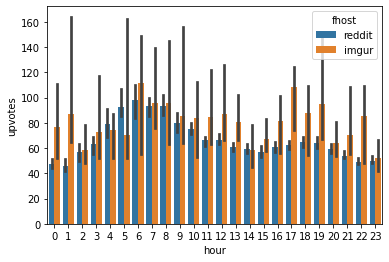

In [34]:
sns.barplot(data=df,x="hour",y="upvotes",estimator=np.median,hue="fhost")

In [18]:
df.url.apply(lambda x: x.split(".")[-1]).value_counts()

jpg     45828
png       733
jpeg       99
gif        70
Name: url, dtype: int64

In [19]:
df["test"] = df.url.apply(lambda x: x.split(".")[-1])

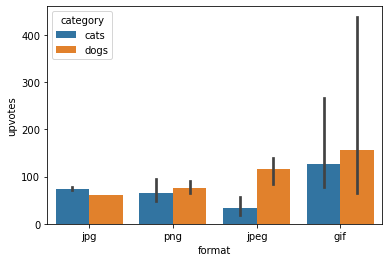

In [35]:
sns.barplot(data=df,x="format",y="upvotes",estimator=np.median,hue="category");

In [36]:
from sklearn.metrics import mean_squared_error as mse

In [37]:
df["benchmark"] = df.target.mean()

In [38]:
mse(df.target,df.benchmark,squared=False)

1.3308108920774133

In [42]:
df.columns

Index(['fname', 'url', 'category', 'subreddit', 'title', 'description',
       'upvotes', 'posted', 'scraped', 'niche', 'test', 'age', 'weekday',
       'weekday_number', 'hour', 'date', 'year', 'month', 'yrmnth', 'target',
       'fhost', 'format', 'subscribers', 'competition_subreddit',
       'competition_category', 'competition_total'],
      dtype='object')